<a href="https://colab.research.google.com/github/dalloliogm/wasserstein_playground/blob/main/chestXray_image_generation_VAE_BindBridge_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!uv pip install "git+https://github.com/dalloliogm/PyHealth.git@3e81898f70a3a5d5b10eb4e3e513b1cb4e68f0a9"

Using Python 3.12.12 environment at: /usr
Resolved 79 packages in 2.78s
Prepared 20 packages in 33.94s
Uninstalled 13 packages in 853ms
Installed 20 packages in 246ms
 + littleutils==0.2.4
 + mne==1.10.2
 - numpy==2.0.2
 + numpy==1.26.4
 - nvidia-cudnn-cu12==9.10.2.21
 + nvidia-cudnn-cu12==9.5.1.17
 - nvidia-cusparselt-cu12==0.7.1
 + nvidia-cusparselt-cu12==0.6.3
 - nvidia-nccl-cu12==2.27.5
 + nvidia-nccl-cu12==2.26.2
 + ogb==1.3.6
 + outdated==0.2.2
 + pandarallel==1.6.5
 - pandas==2.2.2
 + pandas==2.3.3
 - pydantic==2.12.3
 + pydantic==2.11.10
 - pydantic-core==2.41.4
 + pydantic-core==2.33.2
 + pyhealth==2.0a8 (from git+https://github.com/dalloliogm/PyHealth.git@3e81898f70a3a5d5b10eb4e3e513b1cb4e68f0a9)
 + rdkit==2025.9.1
 - scikit-learn==1.6.1
 + scikit-learn==1.7.2
 - tokenizers==0.22.1
 + tokenizers==0.21.4
 - torch==2.9.0+cu126
 + torch==2.7.1
 - torchvision==0.24.0+cu126
 + torchvision==0.22.1
 - transformers==4.57.2
 + transformers==4.53.3
 - triton==3.5.0
 + triton==3.3.1


# Chest X-Ray Image Generation using VAE

This notebook illustrates how to use the VAE module to generate X-Ray images, including the new features for conditional generation based on patient features.

We will take the COVID-19 CXR dataset as starting point. This dataset is freely available on Kaggle and contains images of Chest X-Rays from COVID-19 patients.

## Download Data

Data is available from Kaggle. If it is not already available locally, download it with the following command:

In [ ]:
# Download command (uncomment to run)
!curl -L -o ~/Downloads/covid19-radiography-database.zip https://www.kaggle.com/api/v1/datasets/download/tawsifurrahman/covid19-radiography-database
!unzip ~/Downloads/covid19-radiography-database.zip -d ~/Downloads/COVID-19_Radiography_Dataset

## Load Data with PyHealth Datasets

Use the COVID19CXRDataset to load this data. For custom datasets, see the `BaseImageDataset` class.

In [ ]:
from pyhealth.datasets import split_by_visit, get_dataloader
from pyhealth.trainer import Trainer
from pyhealth.datasets import COVID19CXRDataset
from pyhealth.models import VAE
from pyhealth.processors import ImageProcessor
from torchvision import transforms
from pyhealth.processors import SequenceProcessor


import torch
import numpy as np
import matplotlib.pyplot as plt

/home/ubuntu/PyHealth/pyhealth/trainer.py:12: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import trange
/home/ubuntu/PyHealth/pyhealth/sampler/sage_sampler.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


### Load Data and resize images to 64x64

Assuming data is available locally, we load it and apply an ImageProcessor step to resize all the Chest X-Ray images to 64x64.

In [ ]:
# Step 1: Load data
covid19cxr_path = "/home/ubuntu/Downloads/COVID-19_Radiography_Dataset"
base_dataset = COVID19CXRDataset(covid19cxr_path)
image_size = 128

# Step 2: Set task with custom image processing for VAE
image_processor = ImageProcessor(image_size=image_size, mode="L")  # Resize to 128x128 for VAE
sample_dataset = base_dataset.set_task(input_processors={"image": image_processor})


No config path provided, using default config
Initializing covid19_cxr dataset from /home/ubuntu/Downloads/COVID-19_Radiography_Dataset (dev mode: False)
Scanning table: covid19_cxr from /home/ubuntu/Downloads/COVID-19_Radiography_Dataset/covid19_cxr-metadata-pyhealth.csv
Setting task COVID19CXRClassification for covid19_cxr base dataset...
Generating samples with 1 worker(s)...
Collected dataframe with shape: (21165, 6)


Generating samples for COVID19CXRClassification with 1 worker: 100%|██████████| 21165/21165 [00:08<00:00, 2397.69it/s]

Label disease vocab: {'COVID': 0, 'Lung Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}



Processing samples: 100%|██████████| 21165/21165 [00:33<00:00, 630.01it/s]

Generated 21165 samples for task COVID19CXRClassification


### Map disease metadata

We prepare the disease status as an input processor. This will allow us to later generate images conditioned by the disease status - for example, different images for COVID patients vs normal.

In [ ]:
covid_metadata = base_dataset.load_table('covid19_cxr').collect()
vocab = {'COVID': 0, 'Lung Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}

# Add processor for the conditional feature
sample_dataset.input_processors["disease"] = SequenceProcessor()
sample_dataset.input_processors["disease"].code_vocab = vocab

Scanning table: covid19_cxr from /home/ubuntu/Downloads/COVID-19_Radiography_Dataset/covid19_cxr-metadata-pyhealth.csv


### Split Train/Validation/Test

We apply a simple train/validation/test split, to evaluate the performances of the model during training.

In [ ]:
# Split dataset
train_dataset, val_dataset, test_dataset = split_by_visit(
    sample_dataset, [0.6, 0.2, 0.2]
)
train_dataloader = get_dataloader(train_dataset, batch_size=256, shuffle=True)
val_dataloader = get_dataloader(val_dataset, batch_size=256, shuffle=False)
test_dataloader = get_dataloader(test_dataset, batch_size=256, shuffle=False)

# Check data
data = next(iter(train_dataloader))
print("Data keys:", data.keys())
print("Image shape:", data["image"][0].shape)
print(f"Dataset sizes - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Data keys: dict_keys(['image', 'disease'])
Image shape: torch.Size([1, 64, 64])
Dataset sizes - Train: 12699, Val: 4233, Test: 4233


## Basic VAE Training (Image Generation)

Here we train a standard VAE for unconditional image generation.

Note how we are passing the disease state as conditional_feature_key - this will help the model learn to distinguish images based on the disease state.

Note: since this notebook is just a demo, we will only run 5 epochs. Image generation will work much better if the VAE is trained for longer.

In [ ]:
# Define model
model = VAE(
    dataset=sample_dataset,
    feature_keys=["image"],
    label_key="image",
    mode="regression",
    input_type="image",
    input_channel=1,  # Grayscale images from COVID dataset
    input_size=image_size,
    hidden_dim=256,
    conditional_feature_keys=["disease"]
)

# Define trainer
trainer = Trainer(model=model, device="cuda" if torch.cuda.is_available() else "cpu",
                 metrics=["kl_divergence", "mse", "mae"])

# Train (reduce epochs for demo)
trainer.train(
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epochs=5,  # Reduced for demo
    monitor="kl_divergence",
    monitor_criterion="min",
    optimizer_params={"lr": 1e-3},
)

VAE(
  (embedding_model): EmbeddingModel(embedding_layers=ModuleDict(
    (disease): Embedding(4, 256, padding_idx=0)
  ))
  (encoder1): Sequential(
    (0): ResBlock2D(
      (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ELU(alpha=1.0)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (downsampler): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (1): ResBlock2D(
      (conv1): Conv2d(16, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1,

Epoch 0 / 5:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0 / 5: 100%|██████████| 50/50 [00:01<00:00, 42.26it/s]

--- Train epoch-0, step-50 ---
loss: 684415.0706



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 87.58it/s]


--- Eval epoch-0, step-50 ---
kl_divergence: 0.2301
mse: 0.0000
mae: 0.0000
loss: 629927.4173
New best kl_divergence score (0.2301) at epoch-0, step-50



Epoch 1 / 5: 100%|██████████| 50/50 [00:00<00:00, 89.28it/s]

--- Train epoch-1, step-100 ---
loss: 637803.6687



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 161.62it/s]


--- Eval epoch-1, step-100 ---
kl_divergence: 0.1442
mse: 0.0000
mae: 0.0000
loss: 615081.3585
New best kl_divergence score (0.1442) at epoch-1, step-100



Epoch 2 / 5: 100%|██████████| 50/50 [00:00<00:00, 88.87it/s]

--- Train epoch-2, step-150 ---
loss: 626747.6006



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 166.83it/s]


--- Eval epoch-2, step-150 ---
kl_divergence: 0.1394
mse: 0.0000
mae: 0.0000
loss: 609139.3566
New best kl_divergence score (0.1394) at epoch-2, step-150



Epoch 3 / 5: 100%|██████████| 50/50 [00:00<00:00, 88.67it/s]

--- Train epoch-3, step-200 ---
loss: 622129.7700



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 166.27it/s]


--- Eval epoch-3, step-200 ---
kl_divergence: 0.1209
mse: 0.0000
mae: 0.0000
loss: 605630.6415
New best kl_divergence score (0.1209) at epoch-3, step-200



Epoch 4 / 5: 100%|██████████| 50/50 [00:00<00:00, 88.92it/s]

--- Train epoch-4, step-250 ---
loss: 620055.9969



Evaluation: 100%|██████████| 17/17 [00:00<00:00, 168.56it/s]


--- Eval epoch-4, step-250 ---
kl_divergence: 0.1075
mse: 0.0000
mae: 0.0000
loss: 603210.9228
New best kl_divergence score (0.1075) at epoch-4, step-250
Loaded best model


In [ ]:
# Evaluate
print("Evaluation results:")
eval_results = trainer.evaluate(test_dataloader)
print(eval_results)

Evaluation results:


Evaluation: 100%|██████████| 17/17 [00:00<00:00, 164.58it/s]


{'kl_divergence': 0.105581306, 'mse': 1.6925193976353715e-16, 'mae': 9.512142185030825e-09, 'loss': 601720.8088235294}


## Experiment 1: Real vs Reconstructed Images

A Variational AutoEncoder compresses the input images into a latent space, then reconstructs them back.

It is a good practice to plot one or more images before and after reconstruction, to understand how well the model performs.

In this notebook, we only trained the VAE for 5 epochs, so the results will be quite poor. Try increasing the number of epochs to see if it performs better.

Evaluation: 100%|██████████| 17/17 [00:00<00:00, 158.32it/s]


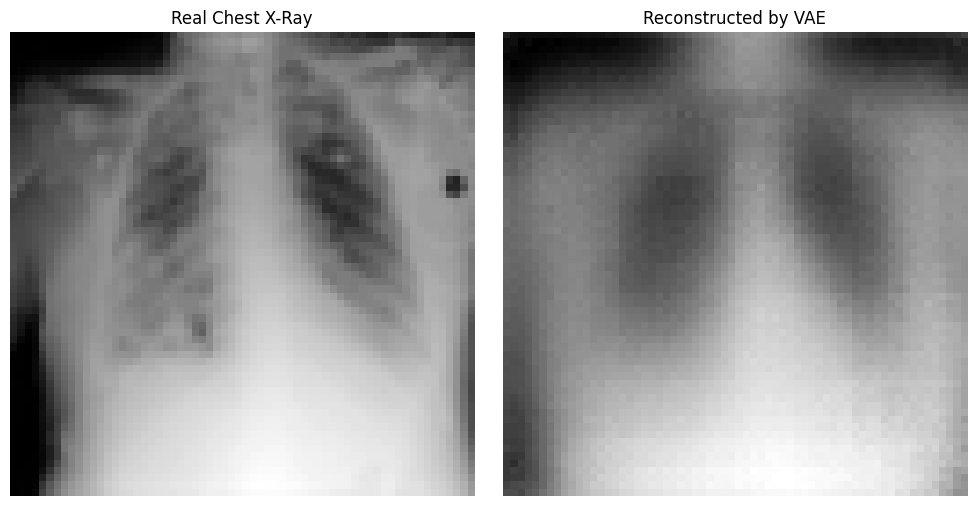

In [ ]:
# Get real and reconstructed images
X, X_rec, _ = trainer.inference(test_dataloader)

# Plot comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(X[0].reshape(image_size, image_size), cmap="gray")
ax1.set_title("Real Chest X-Ray")
ax1.axis('off')

ax2.imshow(X_rec[0].reshape(64, 64), cmap="gray")
ax2.set_title("Reconstructed by VAE")
ax2.axis('off')

plt.tight_layout()
plt.savefig("chestxray_vae_comparison.png", dpi=150)
plt.show()

## Experiment 2: Random Image Generation

Once the VAE has been trained, we can use it to generate new random chest X-Ray images. Results will be better if the model is trained for more epochs.

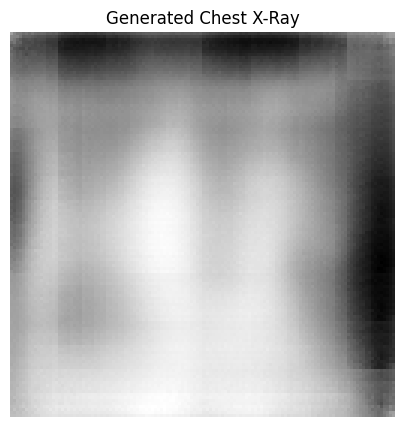

In [ ]:
# Generate synthetic images
model = trainer.model
model.eval()

with torch.no_grad():
    # Sample from latent space
    z = torch.randn(1, model.hidden_dim).to(model.device)

    # Reshape for decoder (add spatial dims)
    z = z.unsqueeze(2).unsqueeze(3)

    # Generate image
    generated = model.decoder(z).detach().cpu().numpy()

    # Plot
    plt.figure(figsize=(5, 5))
    plt.imshow(generated[0].reshape(image_size, image_size), cmap="gray")
    plt.title("Generated Chest X-Ray")
    plt.axis('off')
    plt.savefig("chestxray_vae_synthetic.png", dpi=150)
    plt.show()

## New Feature: Conditional VAE

We  can use the VAE to generate random images, conditioned of patient features, such as the disease state. For example, we can generate images for COVID patients, and compare to normal patients.



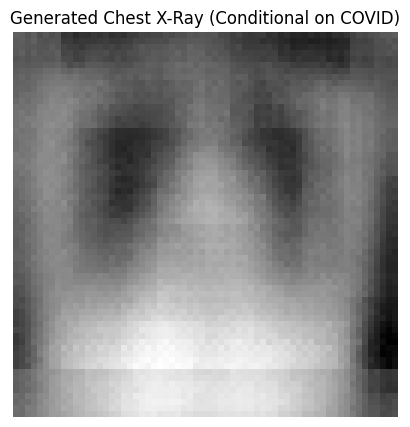

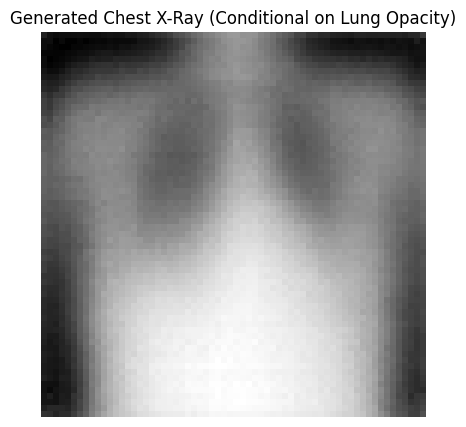

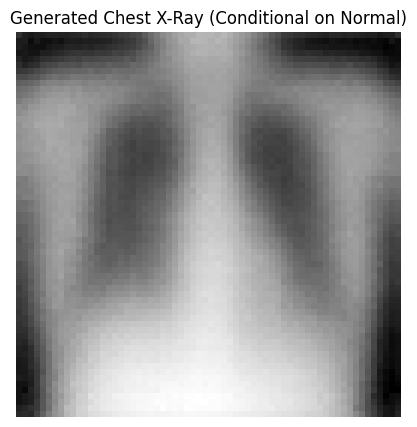

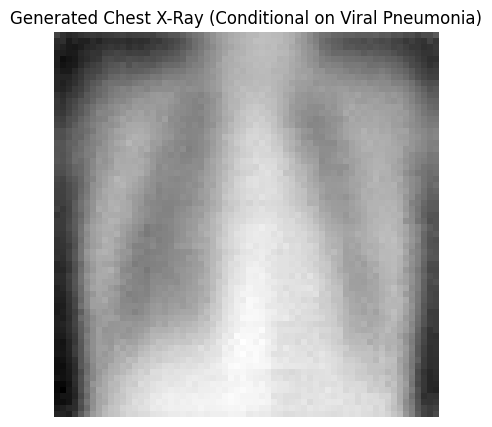

In [ ]:

# Generate conditional images for each disease
model.eval()
vocab = sample_dataset.input_processors["disease"].code_vocab
diseases = list(vocab.keys())

with torch.no_grad():
    for disease in diseases:
        # Sample from latent space
        z = torch.randn(1, model.hidden_dim).to(model.device)

        # Create conditional data
        condition_indices = [vocab[disease]]
        cond_data = {"disease": torch.tensor(condition_indices, dtype=torch.long).unsqueeze(0)}

        # Get embeddings
        cond_embeddings = model.embedding_model(cond_data)
        cond_vec = cond_embeddings["disease"].mean(dim=1)

        # Reshape for decoder
        z_reshaped = z.unsqueeze(2).unsqueeze(3)
        z_reshaped = z_reshaped + cond_vec.unsqueeze(2).unsqueeze(3)

        # Generate image
        generated = model.decoder(z_reshaped).detach().cpu().numpy()

        # Save individual image
        filename = f"conditional_vae_{disease.lower().replace(' ', '_')}.png"
        plt.figure(figsize=(5, 5))
        plt.imshow(generated[0].reshape(image_size, image_size), cmap="gray")
        plt.title(f"Generated Chest X-Ray (Conditional on {disease})")
        plt.axis('off')
        plt.show()
        plt.close()